In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from datetime import datetime

import tensorflow as tf

if not os.path.exists('facenet'):
  !git clone https://github.com/davidsandberg/facenet --depth=1

sys.path.insert(0, './facenet/src')
import align.detect_face
import facenet
import scipy.spatial.distance as distance

In [2]:
# download pre-trained model at https://drive.google.com/open?id=0B5MzpY9kBtDVTGZjcWkzT3pldDA
model_dir = '/home/sabrine/notebook/reid/20170216-091149/'

In [3]:
# starting a session
tf.reset_default_graph()

tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

sess = tf.Session(config=tf_config)

print('loading the detection/alignment network...')
pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
print('done!')

print('loading the embedding network...')
meta_file, ckpt_file = facenet.get_model_filenames(model_dir)
restorer = tf.train.import_meta_graph(os.path.join(model_dir, meta_file))
restorer.restore(sess, os.path.join(model_dir, ckpt_file))
print('done!')

# getting input / output tensors
g = tf.get_default_graph()
images_in = g.get_tensor_by_name('input:0')
phase_train_in = g.get_tensor_by_name('phase_train:0')
embeddings = g.get_tensor_by_name('embeddings:0')


loading the detection/alignment network...
done!
loading the embedding network...
done!


detecting faces...


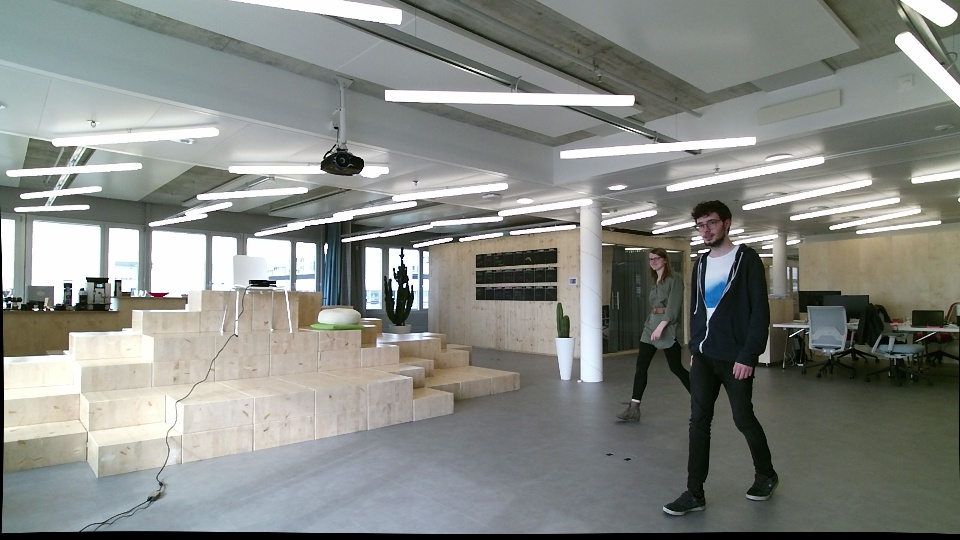

(10, 2)


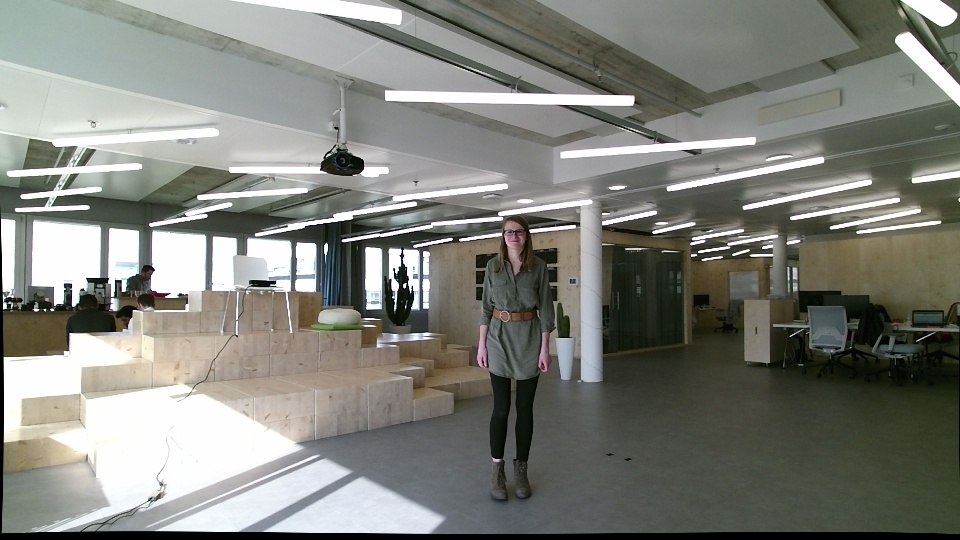

(10, 1)


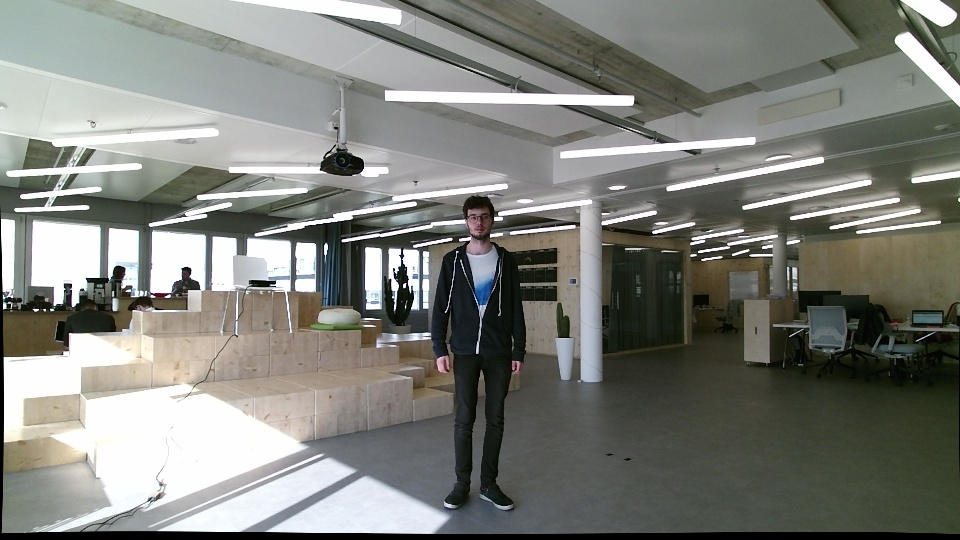

(10, 1)
done!


In [5]:
from IPython.display import Image, display

# detection parameters
minsize = 20 
threshold = [ 0.6, 0.7, 0.7 ]
factor = 0.709
             
boxes = []
keypoints = []
images = []
print('detecting faces...')
for path in ['ac.jpg', 'c.jpg', 'a.jpg']:
  display(Image(path))
  img = scipy.misc.imread(path)
  #img = scipy.misc.imresize(img, [img.shape[0]//4, img.shape[1]//4])
  bbs, kps = align.detect_face.detect_face(img, minsize, 
                                           pnet, rnet, onet, threshold, factor)
  kps = np.asarray(kps)
  print(kps.shape)
  kps = kps.reshape([2,5,-1]).T
  if len(kps) != 0:  
    images.append(img)  
    boxes.append(bbs)
    keypoints.append(kps)
print('done!')  

In [6]:
print('computing embeddings')
size = 160
margin = 32

faces = []
faces_embs = []

for img, bbs in zip(images, boxes):
  img_faces = []
  for x0,y0,x1,y1,_ in bbs.astype(np.int32):
    x0 = np.maximum(x0 - margin//2, 0)
    y0 = np.maximum(y0 - margin//2, 0)
    x1 = np.minimum(x1 + margin//2, img.shape[1])
    y1 = np.minimum(y1 + margin//2, img.shape[0])
    img_faces.append(scipy.misc.imresize(img[y0:y1,x0:x1], (size, size)))
  img_faces = np.stack(img_faces)
  faces.append(img_faces)
  
  feed_dict = {
    images_in : img_faces.astype(np.float32) / 255.0,
      
    phase_train_in : False,
  }
  
  faces_embs.append(sess.run(embeddings, feed_dict))  
print('done!')

computing embeddings
done!


In [7]:
faces[1]

array([[[[155, 152, 147],
         [155, 152, 147],
         [155, 152, 147],
         ..., 
         [253, 250, 253],
         [255, 253, 255],
         [255, 253, 255]],

        [[155, 152, 147],
         [155, 152, 147],
         [155, 152, 147],
         ..., 
         [253, 250, 253],
         [255, 253, 255],
         [255, 253, 255]],

        [[156, 153, 148],
         [156, 153, 148],
         [156, 153, 148],
         ..., 
         [254, 251, 254],
         [255, 253, 255],
         [255, 253, 255]],

        ..., 
        [[ 87,  92,  86],
         [ 87,  92,  86],
         [ 89,  94,  88],
         ..., 
         [ 49,  52,  42],
         [ 49,  51,  42],
         [ 49,  51,  42]],

        [[ 82,  87,  81],
         [ 82,  87,  81],
         [ 85,  90,  84],
         ..., 
         [ 49,  52,  42],
         [ 48,  51,  42],
         [ 48,  51,  42]],

        [[ 81,  86,  80],
         [ 81,  86,  80],
         [ 85,  90,  84],
         ..., 
         [ 49,  52,  42],
  

In [8]:
hostFaces = np.concatenate((faces[1], faces[2]), axis = 0)

In [9]:
hostFaces[0].shape

(160, 160, 3)

In [10]:
host = np.concatenate((faces_embs[1], faces_embs[2]), axis = 0)

0.809287153482
(0, 1)
0.9753432946
(1, 0)


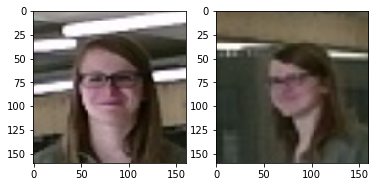

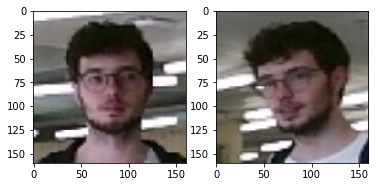

In [11]:
import math
# Euclidian distance of the 2 first picture's faces
# faces_embs is constituted of "embeding picture": so faces_embs[1], faces_embs[0] represents only the 2 first pictures

dist = distance.cdist(faces_embs[0], host)

for i in range(host.shape[0]):
    # idx is the arg i that minimize the euclidian distance between the face of faces_embs[1] and faces_embs[2]
      idx = np.argmin(dist[i])
      print(np.min(dist[i]))
      plt.figure()
      plt.subplot(1,2,1)
      plt.imshow(hostFaces[i])
      plt.subplot(1,2,2)
      plt.imshow(faces[0][idx])
      print(i, idx)